In [1]:
import sys 
import os 
import pickle
import random
import numpy as np 
from astropy.io import fits
from astropy.coordinates import SkyCoord  
import astropy.units as u
import matplotlib.pylab as plt 
import pandas as pd 

plt.rc('text', usetex=True) # - Imperial cluster cannot find Latex
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

# Notes
Important columns identified in the catalogue.

## Positions on the sky
- ALPHA_J2000 (deg)
- DELTA_J2000 (deg)

## Ellipticities and Weights
- e1
- e2
- weight

## Flux
- FLUX_GAAP_u (count)
- FLUX_GAAP_g (count)
- FLUX_GAAP_r (count)
- FLUX_GAAP_i (count)
- FLUX_GAAP_Z (count)
- FLUX_GAAP_Y (count)
- FLUX_GAAP_J (count)
- FLUX_GAAP_H (count)
- FLUX_GAAP_Ks (count)

## Flux Errors
- FLUXERR_GAAP_u (count)
- FLUXERR_GAAP_g (count)
- FLUXERR_GAAP_r (count)
- FLUXERR_GAAP_i (count)
- FLUXERR_GAAP_Z (count)
- FLUXERR_GAAP_Y (count)
- FLUXERR_GAAP_J (count)
- FLUXERR_GAAP_H (count)
- FLUXERR_GAAP_Ks (count)

## Magnitude
- MAG_GAAP_u (mag)
- MAG_GAAP_g (mag)
- MAG_GAAP_r (mag)
- MAG_GAAP_i (mag)
- MAG_GAAP_Z (mag)
- MAG_GAAP_Y (mag)
- MAG_GAAP_J (mag)
- MAG_GAAP_H (mag)
- MAG_GAAP_Ks (mag)

## Magnitude Error
- MAGERR_GAAP_u (mag)
- MAGERR_GAAP_g (mag)
- MAGERR_GAAP_r (mag)
- MAGERR_GAAP_i (mag)
- MAGERR_GAAP_Z (mag)
- MAGERR_GAAP_Y (mag)
- MAGERR_GAAP_J (mag)
- MAGERR_GAAP_H (mag)
- MAGERR_GAAP_Ks (mag)

## Magnitude Limit
- MAG_LIM_u (mag)
- MAG_LIM_g (mag)
- MAG_LIM_r (mag)
- MAG_LIM_i (mag)
- MAG_LIM_Z (mag)
- MAG_LIM_Y (mag)
- MAG_LIM_J (mag)
- MAG_LIM_H (mag)
- MAG_LIM_Ks (mag)

## Flag (all of them 0)
- FLAG_GAAP_u
- FLAG_GAAP_g
- FLAG_GAAP_r
- FLAG_GAAP_i
- FLAG_GAAP_Z
- FLAG_GAAP_Y
- FLAG_GAAP_J
- FLAG_GAAP_H
- FLAG_GAAP_Ks

## BPZ
- M_0 (reference magnitude for BPZ prior)
- Z_B (9 band BPZ redshift estimate - peak of posterior)
- Z_ML (9 band BPZ maximum likelihood redshift)
- Z_B_MIN (lower bound of the 68% confidence interval of Z_B)
- Z_B_MAX (upper bound of the 68% confidence interval of Z_B)

# Plot Objects on the Sky

We have chosen the first 500 000 objects in the catalogue. Takes a long time to plot all the samples. 

In [ ]:
fits_image = fits.open('./data/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat.fits')
data = fits_image[1].data
fits_image.close()

In [ ]:
xarr, yarr = data['ALPHA_J2000'], data['DELTA_J2000']
nobjects = 1000000
idx = random.sample(range(len(xarr)), nobjects)
eq = SkyCoord(xarr[idx], yarr[idx], unit=u.deg)
gal = eq.galactic
colors = np.random.random((nobjects, 3))

In [ ]:
plt.figure(figsize = (12, 8))
plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, s=10, c=colors, alpha=0.6, edgecolors=colors, rasterized=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig('plots/skymap.pdf', bbox_inches = 'tight')
plt.show()

# Processing

Process the data in such as way that we have 6 files stored 

- flux 
- flux errors 
- magnitude
- magnitude error 
- BPZ 
- meta data 

We can process the whole data and this will be stored in data/processed or we can take a subset of $N$ galaxies and these will be stored in data/sets.

In [2]:
from src.processing import cleaning 

In [3]:
fits_image = fits.open('data/catalogue/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat.fits')

# cleaning  (done once)
# whole_data = cleaning(fits_image, save = True, folder = 'data/processed')

print('-'*50)

for i in range(5):
    set_galaxies = cleaning(fits_image, save = True, ngalaxies = 100, folder = f'data/sets/set_{i+1}')
    print('-'*50)

fits_image.close()

Size of flux dataframe 729M
Size of flux errors dataframe 729M
Size of magnitude dataframe 364M
Size of magnitude errors dataframe 364M
Size of BPZ dataframe 202M
Size of meta dataframe 202M
Size of flux dataframe 3K
Size of flux errors dataframe 3K
Size of magnitude dataframe 1K
Size of magnitude errors dataframe 1K
Size of BPZ dataframe 1K
Size of meta dataframe 1K
--------------------------------------------------
Size of flux dataframe 3K
Size of flux errors dataframe 3K
Size of magnitude dataframe 1K
Size of magnitude errors dataframe 1K
Size of BPZ dataframe 1K
Size of meta dataframe 1K
--------------------------------------------------
Size of flux dataframe 3K
Size of flux errors dataframe 3K
Size of magnitude dataframe 1K
Size of magnitude errors dataframe 1K
Size of BPZ dataframe 1K
Size of meta dataframe 1K
--------------------------------------------------
Size of flux dataframe 3K
Size of flux errors dataframe 3K
Size of magnitude dataframe 1K
Size of magnitude errors data

# Tomography

In [2]:
from src.stackz import stack_fitting, stack_predictions
import utils.helpers as hp

In [17]:
BANDWIDTH = 0.05

### Fitting

In [18]:
## Done Once (because the KDEs are then stored)
bpz_redshifts = hp.pickle_load('data/processed', 'bpz')['Z_B']
kdes = stack_fitting(bpz_redshifts.values, save=True, bandwidth=BANDWIDTH, ngalaxies=50000)

### Prediction - Smooth Distribution

In [19]:
redshift_range = np.linspace(0, 2, 1000)
smooth_pdf = stack_predictions(redshift_range, bandwidth=BANDWIDTH, save = False, fname = None)

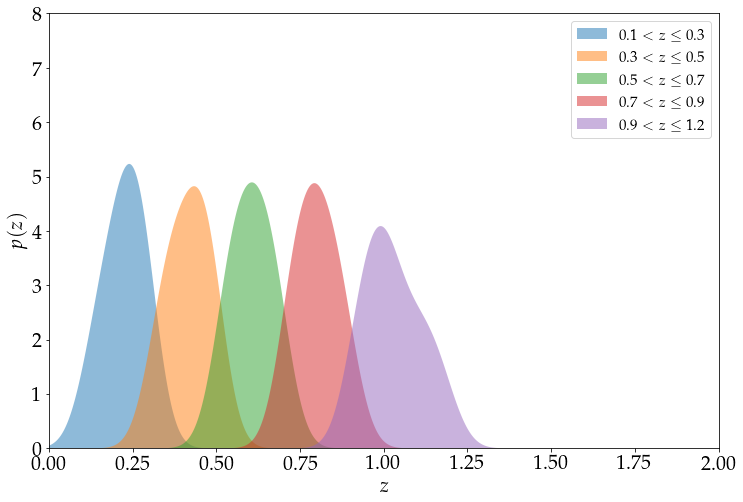

In [20]:
plt.figure(figsize = (12, 8))
plt.fill_between(redshift_range, smooth_pdf['h1'], alpha=0.5, label = r'$0.1<z\leq 0.3$')
plt.fill_between(redshift_range, smooth_pdf['h2'], alpha=0.5, label = r'$0.3<z\leq 0.5$')
plt.fill_between(redshift_range, smooth_pdf['h3'], alpha=0.5, label = r'$0.5<z\leq 0.7$')
plt.fill_between(redshift_range, smooth_pdf['h4'], alpha=0.5, label = r'$0.7<z\leq 0.9$')
plt.fill_between(redshift_range, smooth_pdf['h5'], alpha=0.5, label = r'$0.9<z\leq 1.2$')
plt.ylabel(r'$p(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0.0, 8.0)
plt.xlim(0.0, 2.0)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
# plt.savefig(f'plots/stack_redshift_{BANDWIDTH}.pdf', bbox_inches = 'tight')
plt.show()

### Prediction - KiDS-1000 Mid-Redshifts

In [21]:
# load the fits file
data_tables = fits.open('data/cosmology/kids_1000.fits')

# extract the n(z) distribution
nofz = data_tables['NZ_SOURCE'].data

# get the redshifts
z_mid = np.concatenate((np.zeros(1), nofz['Z_MID']))

In [22]:
kids_pdf = stack_predictions(z_mid, bandwidth=BANDWIDTH, save = True, fname = f'kids_1000_{BANDWIDTH}')

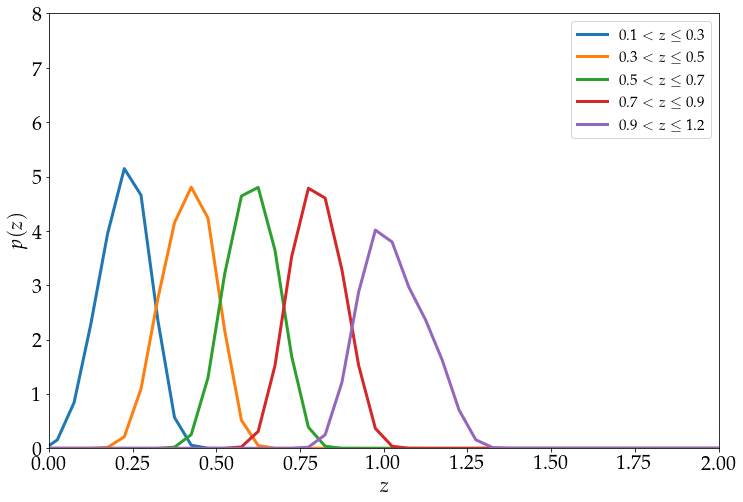

In [23]:
plt.figure(figsize=(12,8))
plt.plot(z_mid, kids_pdf['h1'], lw = 3, label = r'$0.1<z\leq 0.3$')
plt.plot(z_mid, kids_pdf['h2'], lw = 3, label = r'$0.3<z\leq 0.5$')
plt.plot(z_mid, kids_pdf['h3'], lw = 3, label = r'$0.5<z\leq 0.7$')
plt.plot(z_mid, kids_pdf['h4'], lw = 3, label = r'$0.7<z\leq 0.9$')
plt.plot(z_mid, kids_pdf['h5'], lw = 3, label = r'$0.9<z\leq 1.2$')
plt.ylabel(r'$p(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(0.0, 2.0)
plt.ylim(0.0, 8.0)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
# plt.savefig(f'plots/kids_1000_{BANDWIDTH}.pdf', bbox_inches = 'tight')
plt.show()